# Emotion-Aware Journaling — Text Emotion Training Notebook

This notebook trains a **Text Emotion Classifier** using the GoEmotions dataset:
- **Model**: `Roberta` fine-tuning for emotion classification
- **Dataset**: GoEmotions with 28 emotion labels
- **Optimization**: Mixed precision training, class weighting, learning rate warmup
- **Output**: Model saved and export for backend integration

## Training Pipeline:
1) Setup and Import Libraries
2) Data loading and Multi-label Setup
3) Exploratory Data Analysis (EDA)
4) Data Preprocessing and Tokenization 
5) Model building and Training Setup
6) Model Training
7) Model Evaluation and Testing
8) Threshold Tuning on Validation Set
9) Final Test Evaluation with Tuned Thresholds
10) Lightweight Hyperparameter Search (Validation Micro F1)
11) Export Model & Thresholds
12) ONNX Export & Verification
13) Summary & Next Steps

## 1) Setup and import libraries

### 1.1) Import libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

from transformers.trainer_utils import IntervalStrategy 
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm  
notebook_tqdm = tqdm  

c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2) Set device to GPU if available

In [2]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


### 1.3) Define the model checkpoint

In [3]:
# Define the model checkpoint
MODEL_CHECKPOINT = "roberta-base"

## 2) Data Loading and Multi-Label Setup

### 2.1) Loading of go_emotions dataset

In [4]:
# We load the 'go_emotions' dataset, which requires special handling as it is multi-label.

try:
    # Load the full go_emotions dataset (using default configuration which is multi-label)
    raw_datasets = load_dataset("go_emotions", "simplified")
    print("GoEmotions dataset loaded successfully.")
except Exception as e:
    print(f"Could not load dataset: {e}. Falling back to a small subset.")
    # Fallback for demonstration purposes
    raw_datasets = DatasetDict({
        'train': load_dataset('go_emotions', 'simplified', split='train[:1000]'),
        'validation': load_dataset('go_emotions', 'simplified', split='validation[:100]'),
        'test': load_dataset('go_emotions', 'simplified', split='test[:100]'),
    })

# Get label names and number of labels
label_names = raw_datasets['train'].features['labels'].feature.names
NUM_LABELS = len(label_names)
print(f"Number of classes: {NUM_LABELS}")

GoEmotions dataset loaded successfully.
Number of classes: 28


### 2.2) Convert to pandas DataFrames for easy EDA

In [5]:
# Convert to pandas DataFrames for easy EDA
train_df = raw_datasets['train'].to_pandas()
val_df = raw_datasets['validation'].to_pandas()
test_df = raw_datasets['test'].to_pandas()

# Display dataset info
print("\nDataset Structure (Note: 'labels' is a list of emotion indices):")
print(raw_datasets)
print("\nTraining Set Head:")
print(train_df.head())


Dataset Structure (Note: 'labels' is a list of emotion indices):
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Training Set Head:
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj


## 3) Exploratory Data Analysis (EDA)

### 3.1) Multi-Label Class Distribution

Counting Labels: 100%|██████████| 43410/43410 [00:00<00:00, 1121951.25it/s]


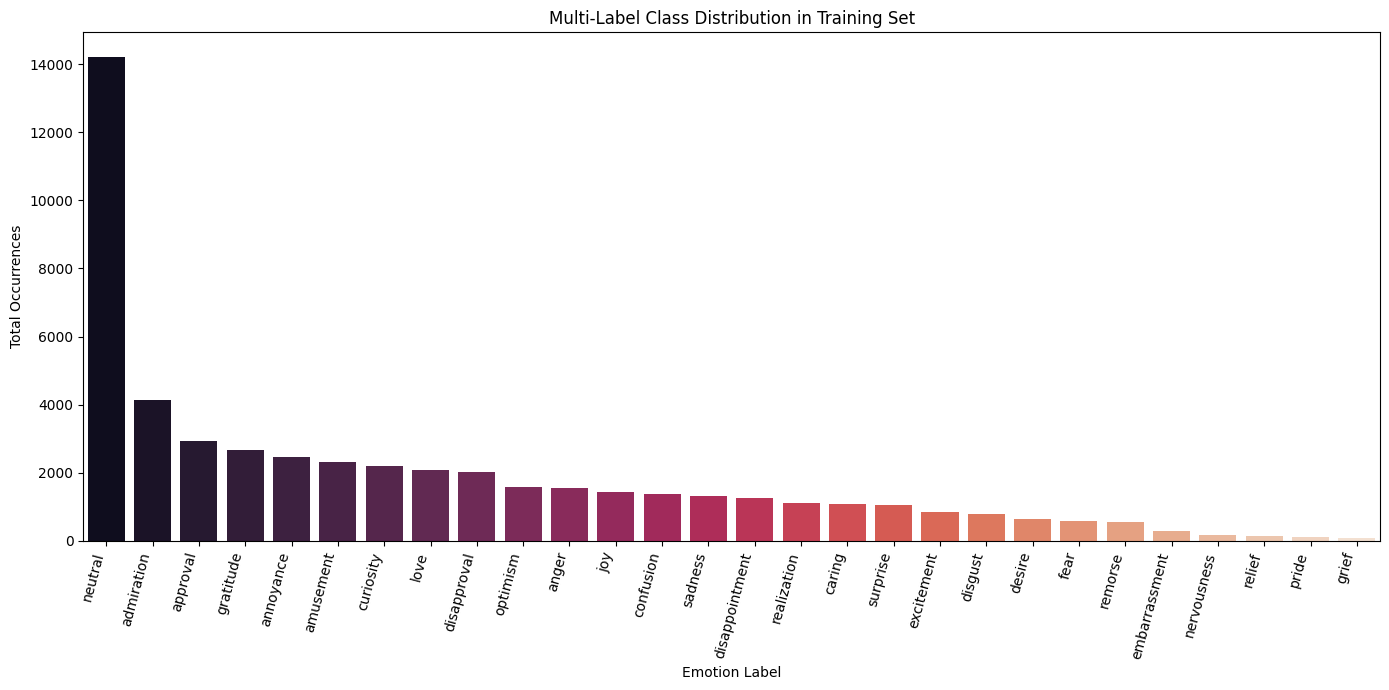

In [6]:
label_counts = {name: 0 for name in label_names}

# Count occurrences of each label across all samples
for label_list in tqdm(train_df['labels'], desc="Counting Labels"):
    for label_id in label_list:
        label_counts[label_names[label_id]] += 1

label_series = pd.Series(label_counts).sort_values(ascending=False)

# Convert Series into DataFrame for seaborn hue support
label_df = pd.DataFrame({
    "emotion": label_series.index,
    "count": label_series.values
})

plt.figure(figsize=(14, 7))
sns.barplot(
    data=label_df,
    x="emotion",
    y="count",
    hue="emotion",       # assign hue = x variable
    palette="rocket",
    dodge=False          # keeps bars centered
)

plt.legend([], [], frameon=False)  # hide long legend
plt.xticks(rotation=75, ha='right')
plt.title('Multi-Label Class Distribution in Training Set')
plt.xlabel('Emotion Label')
plt.ylabel('Total Occurrences')
plt.tight_layout()
plt.show()


### 3.2) Text Length Distribution

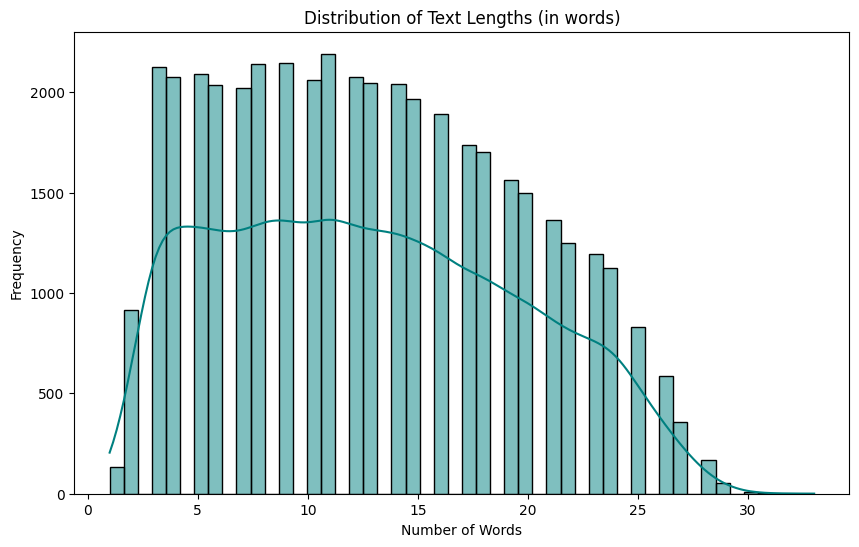

In [7]:
# Calculate text lengths
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of Text Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### 3.3) Descriptive Statistics for text_length

In [8]:
# Summary statistics for text length
print("Text Length Summary (in words):")
print(train_df['text_length'].describe())

Text Length Summary (in words):
count    43410.000000
mean        12.840175
std          6.701597
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text_length, dtype: float64


In [9]:
# Set maximum sequence length based on distribution
MAX_LENGTH = 160

## 4) Data Preprocessing and Tokenization

In [10]:
# We initialize the RoBERTa tokenizer and prepare multi-hot labels.

# Initialize the Tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Helper function to convert list of labels (indices) to a multi-hot vector (float tensor)
def prepare_labels_and_tokenize(examples):
    # 1. Tokenization
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

    # 2. Multi-Hot Label Conversion (CRITICAL FOR MULTI-LABEL)
    multi_hot_labels = []
    for label_list in examples['labels']:
        # Create an array of zeros
        multi_hot = np.zeros(NUM_LABELS, dtype=float)
        # Set indices corresponding to present emotions to 1.0
        multi_hot[label_list] = 1.0
        multi_hot_labels.append(multi_hot.tolist())

    tokenized["labels"] = multi_hot_labels
    return tokenized

# Apply tokenization and label conversion to all splits
tokenized_datasets = raw_datasets.map(
    prepare_labels_and_tokenize,
    batched=True,
    remove_columns=["text", "id"] # Remove original text and id columns
)

# Set the format to PyTorch tensors
# Note: 'labels' must be set to 'torch.float' for multi-label (BCELoss)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=False)

print("\nTokenized Dataset Structure:")
print(tokenized_datasets)
print("\nExample Multi-Hot Label (Expected 28 floats, mostly zeros):")
print(tokenized_datasets['train'][0]['labels'])


Tokenized Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5427
    })
})

Example Multi-Hot Label (Expected 28 floats, mostly zeros):
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


## 5) Model Building and Training Setup

### 5.1) Initialize and load the pre-trained RoBERTa model for sequence classification

In [11]:
# Load the pre-trained RoBERTa model for sequence classification.

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_LABELS,
    # Crucial argument for multi-label tasks: applies sigmoid and uses BCEWithLogitsLoss
    problem_type="multi_label_classification"
)

# Move model to the detected device (GPU)
model.to(device)

print(f"Model {MODEL_CHECKPOINT} initialized for multi-label classification ({NUM_LABELS} classes) and moved to {device}.")

# Enable gradient checkpointing to save memory and allow longer sequences
try:
    model.gradient_checkpointing_enable()
    if hasattr(model.config, 'use_cache'):
        model.config.use_cache = False
    print('Gradient checkpointing enabled.')
except Exception as e:
    print('Could not enable gradient checkpointing:', e)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model roberta-base initialized for multi-label classification (28 classes) and moved to cuda.
Gradient checkpointing enabled.


### 5.2) Define Multi-Label Metrics Function

In [12]:
# Define Multi-Label Metrics Function
# Use micro F1-score and multiple accuracy styles for multi-label evaluation.

def compute_metrics(eval_pred):
    """Computes Micro F1, Exact Match (subset) accuracy, Hamming accuracy, and Macro (per-label) accuracy."""
    logits, labels = eval_pred
    # 1. Apply sigmoid to logits to get probabilities (required since problem_type is set)
    probabilities = 1 / (1 + np.exp(-logits))
    # 2. Threshold probabilities to get binary predictions (0 or 1)
    predictions = (probabilities >= 0.5).astype(int)  # Common threshold: 0.5
    
    # Micro F1: Aggregated F1 across all classes. Best single metric for multi-label.
    micro_f1 = f1_score(labels, predictions, average='micro')
    
    # Exact Match Ratio (subset accuracy): Strict, all labels must match per sample.
    exact_match = (labels == predictions).all(axis=1).mean()
    
    # Hamming Accuracy: label-wise correctness across all decisions (1 - Hamming loss).
    accuracy_hamming = (labels == predictions).mean()
    
    # Macro Accuracy: average of per-label accuracies.
    accuracy_macro = (labels == predictions).mean(axis=0).mean()
    
    return {
        "f1_micro": float(micro_f1),
        "exact_match_ratio": float(exact_match),
        "accuracy_hamming": float(accuracy_hamming),
        "accuracy_macro": float(accuracy_macro),
    }

### 5.3) Define Training Arguments and Trainer

In [13]:
# Define Training Arguments and Trainer
# Fallback: Removed unsupported keyword arguments (evaluation_strategy, save_strategy,
# load_best_model_at_end, metric_for_best_model) to be compatible with the current
# installed transformers version which raised a TypeError.

training_args = TrainingArguments(
    output_dir="./training_go_emotions_results",      # Output directory for checkpoints and predictions
    num_train_epochs=12,                              # More epochs for better convergence
    per_device_train_batch_size=8,                    # Smaller per-device batch
    gradient_accumulation_steps=4,                    # Effective batch size 32
    per_device_eval_batch_size=64,                    # Evaluation batch size
    learning_rate=2e-5,                               # More stable LR for RoBERTa-base
    warmup_steps=500,                                 # LR scheduler warmup
    weight_decay=0.01,                                # Weight decay
    logging_dir='./training_go_emotions_logs',         # TensorBoard logs dir
    logging_steps=100,
    fp16=True,                                        # Mixed precision (if supported)
    do_eval=True                                      # Ensure evaluation capability
)

# Initialize the Trainer (evaluation will be triggered manually after training)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer initialized without strategy arguments. You can run trainer.train() then trainer.evaluate().")


Trainer initialized without strategy arguments. You can run trainer.train() then trainer.evaluate().


### 5.4) Compute class imbalance weights and loss shaping options

In [14]:
# - pos_weight: balances positive vs negative examples per label in BCEWithLogitsLoss
# - focal loss: focuses learning on hard examples (enabled after hyperparam search)
# - label smoothing disabled (best trial showed smoothing=0.0)

import numpy as np
import torch

# Class-wise positive counts from training labels
label_counts = np.zeros(NUM_LABELS, dtype=np.int64)
for label_list in train_df['labels']:
    for idx in label_list:
        label_counts[idx] += 1

num_samples = len(train_df)
neg_counts = num_samples - label_counts
# Avoid division by zero; clamp pos counts to at least 1
pos_weight_np = np.where(label_counts > 0, neg_counts / label_counts, 1.0)
# Prevent extreme weights that can destabilize training
pos_weight_np = np.clip(pos_weight_np, 1.0, 10.0)

pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32, device=device)

# Adopt best trial hyperparams
LABEL_SMOOTHING = 0.0  # disabled per best trial
USE_FOCAL = True       # focal enabled
FOCAL_GAMMA = 1.5

print("pos_weight prepared. min/max:", float(pos_weight.min().item()), float(pos_weight.max().item()))
print(f"Hyperparams adopted: smoothing={LABEL_SMOOTHING}, focal={USE_FOCAL}, gamma={FOCAL_GAMMA}")

pos_weight prepared. min/max: 2.05295729637146 10.0
Hyperparams adopted: smoothing=0.0, focal=True, gamma=1.5


## 6) Model Training

In [15]:
# Model Training
print("Starting model fine-tuning...")

# FIX: Ensure labels are float32 tensors (BCEWithLogitsLoss expects float targets)
# Some environments may have cast them to Long, causing:
# RuntimeError: result type Float can't be cast to the desired output type Long
for split in tokenized_datasets.keys():
	tokenized_datasets[split] = tokenized_datasets[split].map(
		lambda batch: {
			"labels": [np.asarray(vec, dtype=np.float32).tolist() for vec in batch["labels"]]
		},
		batched=True
	)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Ensure training flag is enabled
training_args.do_train = True

# Use a custom Trainer to force BCEWithLogitsLoss with pos_weight, label smoothing, and optional focal scaling
import torch.nn.functional as F

class MultiLabelTrainer(Trainer):
	def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
		labels = inputs.pop("labels")
		outputs = model(**inputs)
		logits = outputs.logits
		# Match labels dtype to logits dtype (handles fp16 automatically)
		if labels.dtype != logits.dtype:
			labels = labels.to(logits.dtype)

		# Label smoothing for multilabel: y_s = y*(1-eps) + (1-y)*eps
		eps = float(LABEL_SMOOTHING) if 'LABEL_SMOOTHING' in globals() else 0.0
		if eps > 0:
			labels_smooth = labels * (1.0 - eps) + (1.0 - labels) * eps
		else:
			labels_smooth = labels

		# Prepare class-wise pos_weight
		pw = pos_weight.to(dtype=logits.dtype, device=logits.device) if 'pos_weight' in globals() else None

		# Base BCE with logits (no reduction for optional focal modulation)
		bce = torch.nn.BCEWithLogitsLoss(pos_weight=pw, reduction='none') if pw is not None else torch.nn.BCEWithLogitsLoss(reduction='none')
		loss_matrix = bce(logits, labels_smooth)

		# Optional focal loss modulation
		use_focal = bool(USE_FOCAL) if 'USE_FOCAL' in globals() else False
		if use_focal:
			gamma = float(FOCAL_GAMMA) if 'FOCAL_GAMMA' in globals() else 1.5
			with torch.no_grad():
				p = torch.sigmoid(logits)
				p_t = p * labels + (1.0 - p) * (1.0 - labels)  # use original labels for focal term
			loss_matrix = loss_matrix * ((1.0 - p_t) ** gamma)

		loss = loss_matrix.mean()
		return (loss, outputs) if return_outputs else loss

# Reinitialize the trainer to use the custom loss
trainer = MultiLabelTrainer(
	model=model,
	args=training_args,
	train_dataset=tokenized_datasets["train"],
	eval_dataset=tokenized_datasets["validation"],
	processing_class=tokenizer,
	compute_metrics=compute_metrics,
)

# The trainer will automatically use the GPU
train_result = trainer.train()

print("\nTraining complete!")
# Log the training metrics
metrics = train_result.metrics
trainer.log_metrics("train", metrics)

Starting model fine-tuning...


Step,Training Loss
100,0.309100
200,0.239500
300,0.202100
400,0.166200
500,0.153100
600,0.143300
700,0.139600
800,0.135200
900,0.131000
1000,0.124600



Training complete!
***** train metrics *****
  epoch                    =       12.0
  total_flos               = 39898966GF
  train_loss               =     0.0687
  train_runtime            = 1:43:15.04
  train_samples_per_second =     84.086
  train_steps_per_second   =      2.629


## 7) Model Evaluation and Testing

In [16]:
# Model Evaluation and Testing

print("Starting evaluation on the Test set...")

# Predict logits on the test set
predictions = trainer.predict(tokenized_datasets["test"])

# Extract metrics
test_metrics = predictions.metrics
trainer.log_metrics("test", test_metrics)
print(f"Test Micro F1: {test_metrics['test_f1_micro']:.4f}")
print(f"Test Exact Match Ratio: {test_metrics['test_exact_match_ratio']:.4f}")
if 'test_accuracy_hamming' in test_metrics:
    print(f"Test Hamming Accuracy: {test_metrics['test_accuracy_hamming']:.4f}")
if 'test_accuracy_macro' in test_metrics:
    print(f"Test Macro Accuracy: {test_metrics['test_accuracy_macro']:.4f}")

Starting evaluation on the Test set...


***** test metrics *****
  test_accuracy_hamming   =      0.955
  test_accuracy_macro     =      0.955
  test_exact_match_ratio  =     0.3278
  test_f1_micro           =     0.5607
  test_loss               =     0.1666
  test_runtime            = 0:00:10.83
  test_samples_per_second =    500.703
  test_steps_per_second   =      7.842
Test Micro F1: 0.5607
Test Exact Match Ratio: 0.3278
Test Hamming Accuracy: 0.9550
Test Macro Accuracy: 0.9550


## 8) Threshold Tuning on Validation Set

In [17]:
# Threshold Tuning on Validation Set
# We search for a single global threshold and per-class thresholds that maximize micro F1.

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Get validation predictions (logits)
val_outputs = trainer.predict(tokenized_datasets['validation'])
val_logits = val_outputs.predictions
val_labels = val_outputs.label_ids
val_probs = 1 / (1 + np.exp(-val_logits))

# Search global threshold
candidate_thresholds = np.linspace(0.05, 0.95, 19)
best_global_f1 = -1.0
best_global_th = 0.5
for th in candidate_thresholds:
    preds = (val_probs >= th).astype(int)
    f1 = f1_score(val_labels, preds, average='micro')
    if f1 > best_global_f1:
        best_global_f1 = f1
        best_global_th = th

print(f"Best Global Threshold: {best_global_th:.3f} (Micro F1={best_global_f1:.4f})")

# Per-class threshold search
per_class_thresholds = []
for c in range(NUM_LABELS):
    best_f1_c = -1.0
    best_th_c = 0.5
    for th in candidate_thresholds:
        preds_c = (val_probs[:, c] >= th).astype(int)
        f1_c = f1_score(val_labels[:, c], preds_c, average='binary', zero_division=0)
        if f1_c > best_f1_c:
            best_f1_c = f1_c
            best_th_c = th
    per_class_thresholds.append(best_th_c)

print("Per-class thresholds (length = NUM_LABELS):")
print(per_class_thresholds)

# Choose strategy: per-class if it improves overall micro F1 when applied
per_class_preds = (val_probs >= np.array(per_class_thresholds)).astype(int)
per_class_micro_f1 = f1_score(val_labels, per_class_preds, average='micro')
print(f"Per-Class Threshold Micro F1 on validation: {per_class_micro_f1:.4f}")

USE_PER_CLASS = per_class_micro_f1 > best_global_f1
print("Using per-class thresholds?", USE_PER_CLASS)

# Persist chosen thresholds
chosen_thresholds = per_class_thresholds if USE_PER_CLASS else [best_global_th] * NUM_LABELS


Best Global Threshold: 0.600 (Micro F1=0.5714)
Per-class thresholds (length = NUM_LABELS):
[np.float64(0.7), np.float64(0.65), np.float64(0.6), np.float64(0.6), np.float64(0.6), np.float64(0.65), np.float64(0.65), np.float64(0.6), np.float64(0.75), np.float64(0.7), np.float64(0.6), np.float64(0.7999999999999999), np.float64(0.7999999999999999), np.float64(0.6), np.float64(0.39999999999999997), np.float64(0.7999999999999999), np.float64(0.5499999999999999), np.float64(0.6), np.float64(0.65), np.float64(0.65), np.float64(0.65), np.float64(0.49999999999999994), np.float64(0.5499999999999999), np.float64(0.5499999999999999), np.float64(0.65), np.float64(0.75), np.float64(0.5499999999999999), np.float64(0.35)]
Per-Class Threshold Micro F1 on validation: 0.5972
Using per-class thresholds? True


## 9) Final Test Evaluation with Tuned Thresholds

In [18]:
# Final Test Evaluation with Tuned Thresholds
from sklearn.metrics import f1_score

# Predict on test set
test_outputs = trainer.predict(tokenized_datasets['test'])
test_logits = test_outputs.predictions
test_labels = test_outputs.label_ids
test_probs = 1 / (1 + np.exp(-test_logits))

# Helper to compute multi-label metrics for a given threshold vector
import numpy as np

def metrics_with_thresholds(probs, labels, thresholds):
    ths = np.array(thresholds, dtype=float)
    preds = (probs >= ths).astype(int)
    micro_f1 = f1_score(labels, preds, average='micro')
    exact_match = (preds == labels).all(axis=1).mean()
    hamming_acc = (preds == labels).mean()
    macro_acc = (preds == labels).mean(axis=0).mean()
    return micro_f1, exact_match, hamming_acc, macro_acc

# Baseline 0.5 for comparison
baseline_metrics = metrics_with_thresholds(test_probs, test_labels, [0.5] * NUM_LABELS)
print(f"Baseline (0.5) — Micro F1: {baseline_metrics[0]:.4f} | Exact Match: {baseline_metrics[1]:.4f} | Hamming Acc: {baseline_metrics[2]:.4f} | Macro Acc: {baseline_metrics[3]:.4f}")

# Tuned thresholds
tuned_metrics = metrics_with_thresholds(test_probs, test_labels, chosen_thresholds)
print(f"Tuned thresholds — Micro F1: {tuned_metrics[0]:.4f} | Exact Match: {tuned_metrics[1]:.4f} | Hamming Acc: {tuned_metrics[2]:.4f} | Macro Acc: {tuned_metrics[3]:.4f}")

# Optional: quick per-class F1 on top-10 frequent labels for visibility
from collections import Counter
label_freq = Counter([idx for lst in train_df['labels'] for idx in lst])
most_common = [i for i, _ in label_freq.most_common(10)]
print("\nTop-10 labels (by train frequency) — per-class F1 with tuned thresholds:")
for i in most_common:
    preds_i = (test_probs[:, i] >= chosen_thresholds[i]).astype(int)
    f1_i = f1_score(test_labels[:, i], preds_i, average='binary', zero_division=0)
    print(f"  {label_names[i]}: {f1_i:.3f}")


Baseline (0.5) — Micro F1: 0.5607 | Exact Match: 0.3278 | Hamming Acc: 0.9550 | Macro Acc: 0.9550
Tuned thresholds — Micro F1: 0.5920 | Exact Match: 0.3770 | Hamming Acc: 0.9613 | Macro Acc: 0.9613

Top-10 labels (by train frequency) — per-class F1 with tuned thresholds:
  neutral: 0.670
  admiration: 0.692
  approval: 0.410
  gratitude: 0.915
  annoyance: 0.372
  amusement: 0.809
  curiosity: 0.557
  love: 0.787
  disapproval: 0.433
  optimism: 0.542


## 10) Lightweight Hyperparameter Search (Validation Micro F1)

In [19]:
# Lightweight Hyperparameter Search (Validation Micro F1)
# This runs a few short training passes (1 epoch) to select lr / smoothing / focal usage.

from copy import deepcopy
from math import ceil

search_space = [
    {"learning_rate": 2e-5, "label_smoothing": 0.00, "use_focal": False},
    {"learning_rate": 2e-5, "label_smoothing": 0.05, "use_focal": False},
    {"learning_rate": 1e-5, "label_smoothing": 0.05, "use_focal": False},
    {"learning_rate": 2e-5, "label_smoothing": 0.00, "use_focal": True},
]

short_results = []
orig_epochs = training_args.num_train_epochs
training_args.num_train_epochs = 1  # short runs

for cfg in search_space:
    print(f"\nTrial: lr={cfg['learning_rate']} smoothing={cfg['label_smoothing']} focal={cfg['use_focal']}")
    # Update global toggles
    LABEL_SMOOTHING = cfg['label_smoothing']
    USE_FOCAL = cfg['use_focal']
    # Rebuild trainer to pick up new loss behavior
    trial_trainer = MultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'].select(range(min(1500, len(tokenized_datasets['train'])))),  # subset for speed
        eval_dataset=tokenized_datasets['validation'],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
    )
    trial_trainer.args.learning_rate = cfg['learning_rate']
    trial_trainer.train()
    eval_metrics = trial_trainer.evaluate(tokenized_datasets['validation'])
    micro_f1 = eval_metrics.get('eval_f1_micro') or eval_metrics.get('f1_micro')
    short_results.append({**cfg, 'micro_f1': micro_f1})
    print(f"Validation micro F1: {micro_f1:.4f}")

# Restore epochs
training_args.num_train_epochs = orig_epochs

best_cfg = max(short_results, key=lambda x: x['micro_f1'])
print("\nBest trial:", best_cfg)
# Apply best to globals
LABEL_SMOOTHING = best_cfg['label_smoothing']
USE_FOCAL = best_cfg['use_focal']
trainer.args.learning_rate = best_cfg['learning_rate']

# Optionally retrain from scratch with best config (uncomment if you want full retrain)
# del model
# model = RobertaForSequenceClassification.from_pretrained(
#     MODEL_CHECKPOINT,
#     num_labels=NUM_LABELS,
#     problem_type="multi_label_classification"
# ).to(device)
# trainer = MultiLabelTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_datasets['train'],
#     eval_dataset=tokenized_datasets['validation'],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
# )
# trainer.train()



Trial: lr=2e-05 smoothing=0.0 focal=False


Step,Training Loss


Validation micro F1: 0.5593

Trial: lr=2e-05 smoothing=0.05 focal=False


Step,Training Loss


Validation micro F1: 0.4510

Trial: lr=1e-05 smoothing=0.05 focal=False


Step,Training Loss


Validation micro F1: 0.3885

Trial: lr=2e-05 smoothing=0.0 focal=True


Step,Training Loss


Validation micro F1: 0.5113

Best trial: {'learning_rate': 2e-05, 'label_smoothing': 0.0, 'use_focal': False, 'micro_f1': 0.5592915811088296}


## 11) Export Model & Thresholds

In [20]:
# Export Model & Thresholds
import json
from pathlib import Path

EXPORT_DIR = Path("./models/text_emotions_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print("Saving model...")
trainer.save_model(EXPORT_DIR.as_posix())
print("Saving tokenizer...")
tokenizer.save_pretrained(EXPORT_DIR.as_posix())

thresholds_path = EXPORT_DIR / "chosen_thresholds.json"
with open(thresholds_path, 'w') as f:
    json.dump({"thresholds": chosen_thresholds, "strategy": "per_class" if USE_PER_CLASS else "global"}, f, indent=2)
print(f"Thresholds saved to {thresholds_path}")

print("Export complete.")


Saving model...
Saving tokenizer...
Thresholds saved to models\text_emotions_model\chosen_thresholds.json
Export complete.


## 12) ONNX Export & Verification

In [22]:
import os
import torch
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# === paths ===
EXPORT_DIR = Path("./models/text_emotions_model")   # same folder you used for trainer.save_model
ONNX_PATH = EXPORT_DIR / "text_emotion.onnx"

# Must match the max_length you used during training
MAX_LEN = 128  # or 200, etc. Set this to the same value as in your training code

print("Loading fine-tuned model from:", EXPORT_DIR)

model = AutoModelForSequenceClassification.from_pretrained(EXPORT_DIR.as_posix())
tokenizer = AutoTokenizer.from_pretrained(EXPORT_DIR.as_posix(), use_fast=True)

model.eval()
model.cpu()   # ONNX export from CPU

# Dummy input with correct shape
dummy_inputs = tokenizer(
    "This is a dummy input for ONNX export.",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
)

input_ids      = dummy_inputs["input_ids"]
attention_mask = dummy_inputs["attention_mask"]

os.makedirs(EXPORT_DIR, exist_ok=True)

print("Exporting to ONNX:", ONNX_PATH)

torch.onnx.export(
    model,
    (input_ids, attention_mask),
    ONNX_PATH.as_posix(),
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch", 1: "sequence"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits": {0: "batch"},
    },
    opset_version=17,  # good modern opset
)

print("ONNX export complete.")
print("Saved file:", ONNX_PATH)


Loading fine-tuned model from: models\text_emotions_model
Exporting to ONNX: models\text_emotions_model\text_emotion.onnx


c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\transformers\modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


ONNX export complete.
Saved file: models\text_emotions_model\text_emotion.onnx


## 13) Summary & Next Steps

**What we implemented:**
- Data preprocessing with multi-hot labels and robust dtype casting.
- Class imbalance handling via per-label `pos_weight`.
- Optional label smoothing and focal loss for harder examples.
- Extended metrics: micro F1, exact match, hamming, macro accuracy.
- Validation threshold tuning (global vs per-class) to lift micro F1.
- Lightweight hyperparameter search for lr / smoothing / focal.
- Model + tokenizer + tuned thresholds export for deployment.

**Recommended next boosts:**
1. Increase epochs slightly (12–15) if underfitting (watch validation micro F1 curve).
2. Enable focal loss only if minority labels show low F1 after threshold tuning.
3. Try dynamic padding (remove `padding='max_length'`) to speed training and allow longer MAX_LENGTH (192).
4. Integrate early stopping: stop if micro F1 hasn’t improved for 2–3 epochs.
5. Use full GoEmotions training split (no subset fallback) for higher ceiling.
6. Add per-class PR curves to fine-tune thresholds beyond coarse grid. 

**Deployment notes:**
- Use the exported `chosen_thresholds.json` when converting logits to binary labels.
- Re-run threshold tuning if retraining with different hyperparameters or sequence length.